# Trying a new method for beersheba implementation:

- high q cut, high e cut, high number of iterations
- extra drop isolated clusters post deconvolution
- track glueing

In [2]:
import sys,os,os.path
sys.path.append("../../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 23

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import invisible_cities.core.core_functions                   as     coref
import invisible_cities.io.dst_io                           as     dstio

from invisible_cities.cities.beersheba                 import cut_over_Q, drop_isolated, deconvolve_signal


from invisible_cities.database.load_db       import DataSiPM

from invisible_cities.evm.event_model        import Cluster, Hit
from invisible_cities.types.ic_types         import xy
from invisible_cities.reco.paolina_functions import voxelize_hits

from invisible_cities.evm.event_model        import HitEnergy
from invisible_cities.cities.beersheba          import DeconvolutionMode
from invisible_cities.cities.beersheba          import CutType


from invisible_cities.reco.deconv_functions import deconvolve
from invisible_cities.reco.deconv_functions import deconvolution_input
from invisible_cities.reco.deconv_functions import InterpolationMethod

import invisible_cities.io.mcinfo_io as mcio


import matplotlib.cm as cm
from matplotlib.colors import Normalize

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import glob

# Input file and some event IDs to look at.

typefile = 'sophronia' #'esmeralda'
RUN = 15589
fpath = f'/home/e78368jw/Downloads/test_data/15589/sophronia/trigger2/ldc1/'
#fpath = f'/data/halmazan/NEXT/N100_LPR/15589/sophronia/prod/ldc1/'
#file_pattern = f'{fpath}run_{RUN}_*_ldc1_trg2.v2.3.1.20250708.HEDesman.sophronia.h5'
#file_pattern = f'{fpath}run_{RUN}_*_ldc1_trg2.v2.3.1.20250429.HEDesman.sophronia.h5'
file_pattern = f'{fpath}run_{RUN}_*'
files = glob.glob(file_pattern)

print(file_pattern)
# Select the first file that matches the pattern
file = files[0] if files else None

pitch = 15.55

detector_db     = '/home/e78368jw/Documents/NEXT_CODE/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
#detector_db     = '/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = RUN

datatype = 'data'

#n_iters = 50
#q_cut = 8
#e_cut = 0.2
#cut_T = CutType.rel

n_iters = 75
q_cut   = 10 
e_cut   = 0.004
cut_T   = CutType.abs
# Parameters involved in beersheba city and the deconvolution.
nhits = 3
deconv_params = dict(
  q_cut            = q_cut, #5 for 6mm  - 5 for 6mm
  drop_dist        = [16, 16, 4],
  #psf_fname        = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname        = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/051125_full_25us.psf',     
  #psf_fname        = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/040925_full_25us.psf',     
  #psf_fname        = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/NEXT100_PSF_kr83m.h5',     
  e_cut            = e_cut, #15 for 6mm  - 15 for 6mm
  n_iterations     = n_iters, #150 for 6mm  - 150 for 6mm
  iteration_tol    =  1e-10,
  sample_width     = [15.55, 15.55],
  bin_size         = [ 1,  1],
  diffusion        = (1., 1.),
  n_dim            = 2,
  deconv_mode      = DeconvolutionMode.joint,
  cut_type         = cut_T,
  energy_type      = HitEnergy.Ec,
  satellite_params = None)
  #satellite_params = dict(satellite_start_iter = 1,
  #                        satellite_max_size   = 10,
  #                        e_cut                = e_cut,
  #                        cut_type             = cut_T))#,
  
 # inter_method    = InterpolationMethod.cubic)
deconv_params_          = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}
cut_sensors       = cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'], nhits)



/home/e78368jw/Downloads/test_data/15589/sophronia/trigger2/ldc1/run_15589_*


## small file selection example

In [4]:
# load in the file
hdst = dstio.load_dsts(files[:3], 'RECO', 'Events')
dst = dstio.load_dsts(files[:3], 'DST', 'Events')

In [5]:

# ROI dataset
cutdst = hdst[hdst.groupby('event').Ec.transform('sum').between(1.3, 1.8)]

In [6]:
evt  = cutdst.event.unique()[9]
print(cutdst.event.unique())
#evt  = cutdst.event.unique()[11]
hits = cutdst[cutdst.event == evt]

print(evt)

[13819 14036 14141 14428 14547 56687 56736 56792 56883 57037 57065 57107
 57247 57338 24270 24536 24795 24802]
57037


In [7]:
def plot_hits(hits, bins = None):
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    if bins is None:
        print('No binning provided, extracting from hits')
        xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
        yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
        zz = hits.Z.unique()
    else:
        xx = bins[0]
        yy = bins[1]
        zz = bins[2]
    # set weights to be either hits.Q or hits.E based on what the df has 
    if 'Q' in hits:
        weight = hits.Q
    else:
        weight = hits.E
    axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=weight, cmin=0.0000000001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=weight, cmin=0.0000000001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=weight, cmin=0.0000000001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Sensors Signal', fontsize=30)

No binning provided, extracting from hits


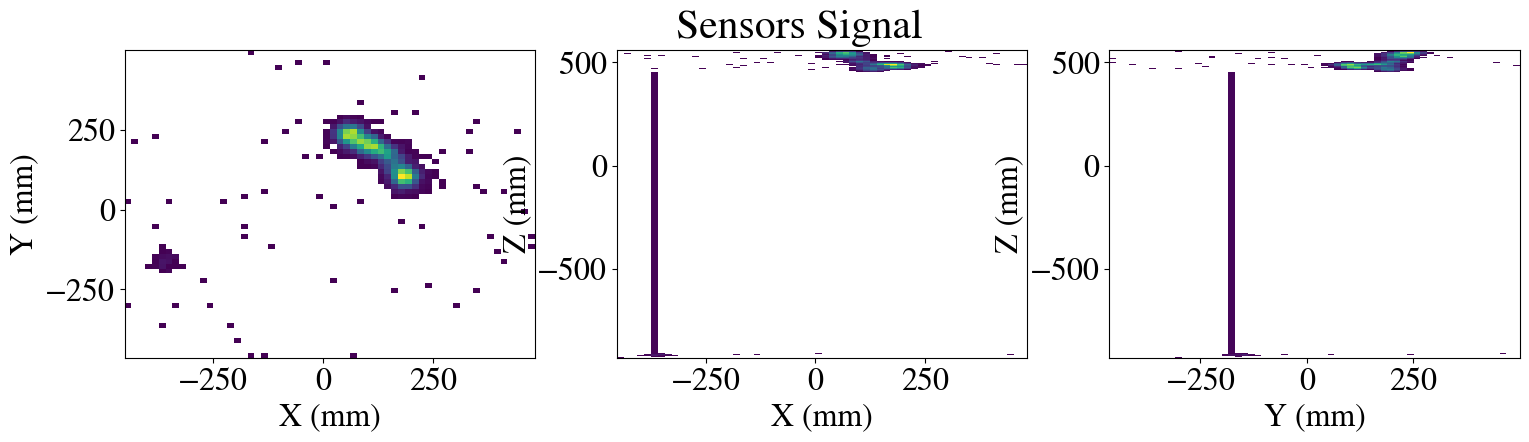

In [8]:
plot_hits(hits)
xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()
bins = (xx, yy, zz)


# Cut data

In [9]:
display(hits)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
52082,57037,1.751991e+09,0,-171.760897,-49.048123,1,-451.525,-294.825,0.0,0.0,-931.133614,7.309861,321.651062,-1.0,NaN,-1,-1.0
52083,57037,1.751991e+09,0,-171.760897,-49.048123,1,-359.225,-155.875,0.0,0.0,-927.197223,8.071969,306.110397,-1.0,0.001604,-1,-1.0
52084,57037,1.751991e+09,0,-171.760897,-49.048123,1,-343.675,-155.875,0.0,0.0,-927.197223,7.946406,301.348729,-1.0,0.001546,-1,-1.0
52085,57037,1.751991e+09,0,-171.760897,-49.048123,1,-373.775,-171.425,0.0,0.0,-923.407253,7.198445,125.479546,-1.0,0.000694,-1,-1.0
52086,57037,1.751991e+09,0,-171.760897,-49.048123,1,-359.225,-171.425,0.0,0.0,-923.407253,11.755236,204.911153,-1.0,0.001089,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53325,57037,1.751991e+09,24,76.672308,111.034828,1,88.725,230.375,0.0,0.0,555.910250,8.589403,69.550571,-1.0,0.000370,-1,-1.0
53326,57037,1.751991e+09,24,76.672308,111.034828,1,88.725,245.925,0.0,0.0,555.910250,13.593873,110.073031,-1.0,0.000587,-1,-1.0
53327,57037,1.751991e+09,24,76.672308,111.034828,1,57.625,260.475,0.0,0.0,555.910250,11.895000,96.316829,-1.0,0.000511,-1,-1.0
53328,57037,1.751991e+09,24,76.672308,111.034828,1,73.175,260.475,0.0,0.0,555.910250,9.864754,79.877408,-1.0,0.000425,-1,-1.0


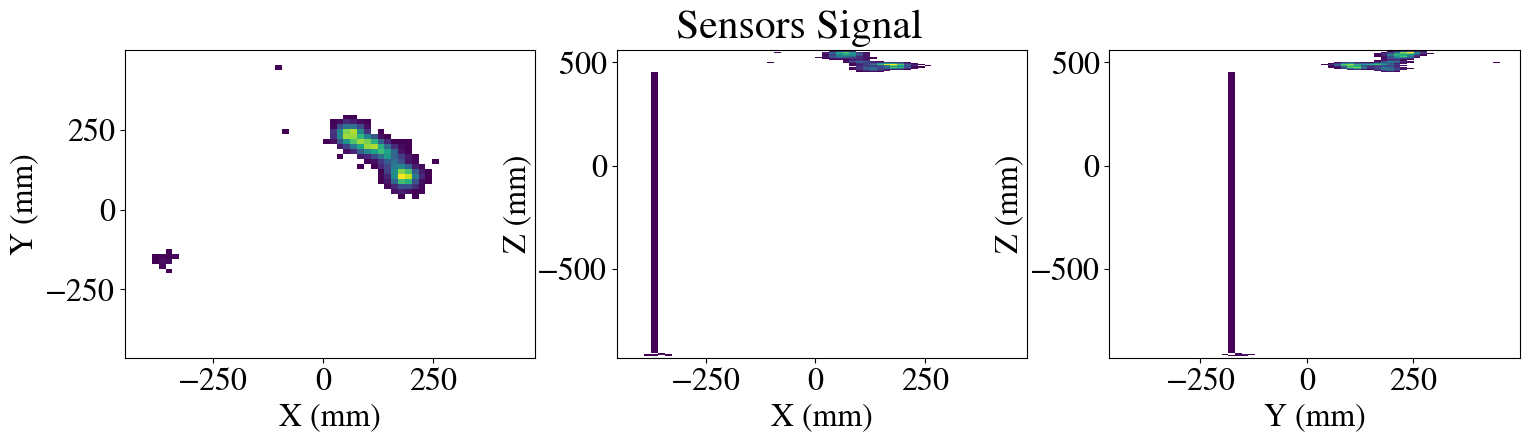

In [10]:
hits_cut = cut_sensors(hits.copy())
plot_hits(hits_cut, bins)

# Drop isolated clusters

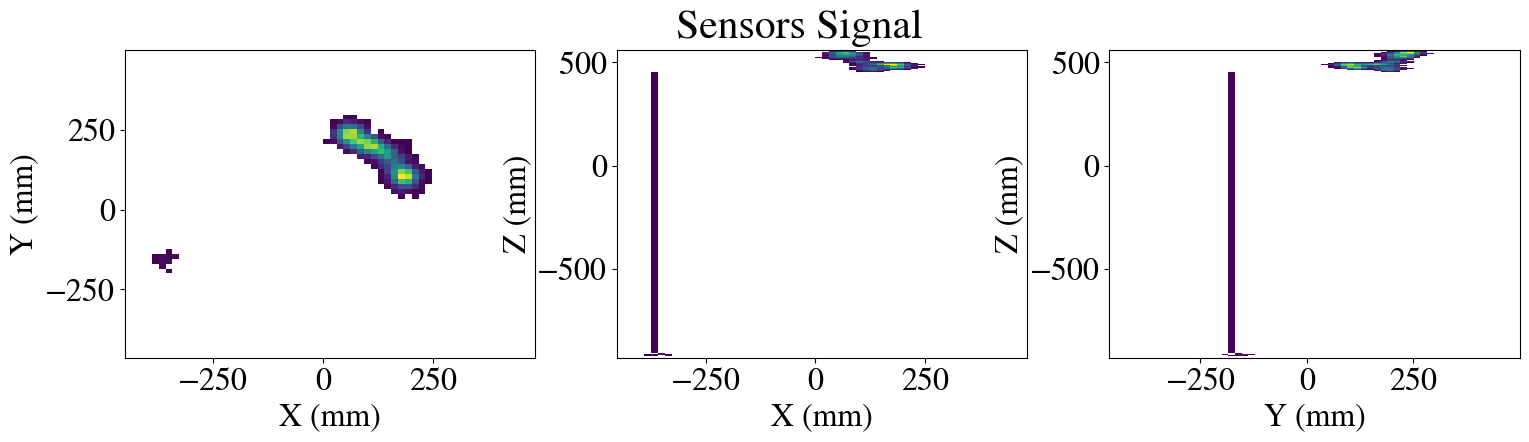

In [11]:
hits_drop = drop_sensors(hits_cut.copy())
plot_hits(hits_drop, bins)

# Deconvolve

In [12]:
deconvolver = deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = deconvolver(hits_drop)

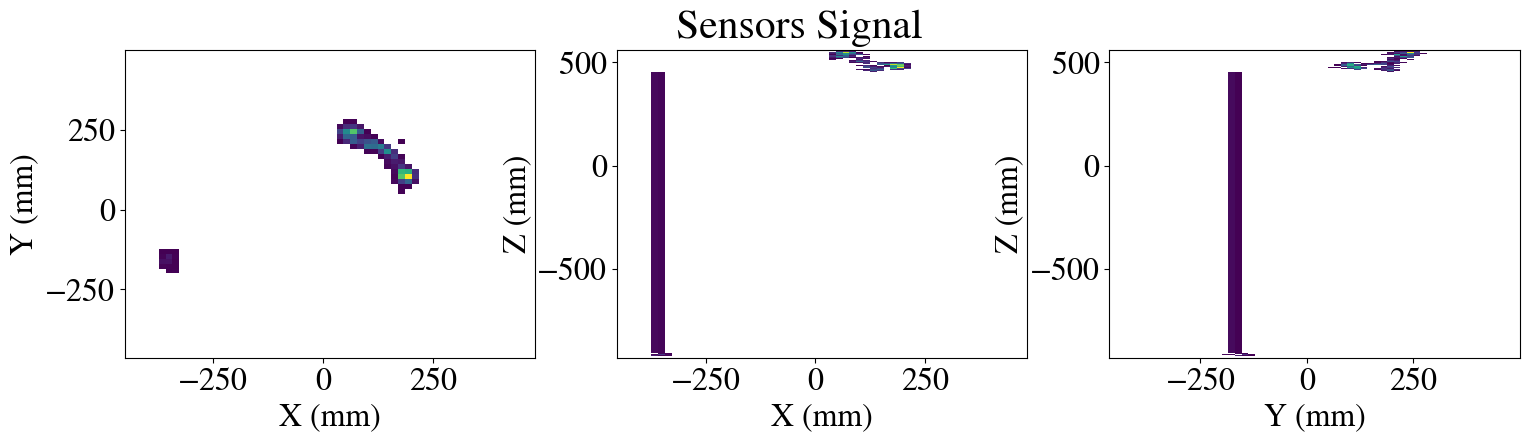

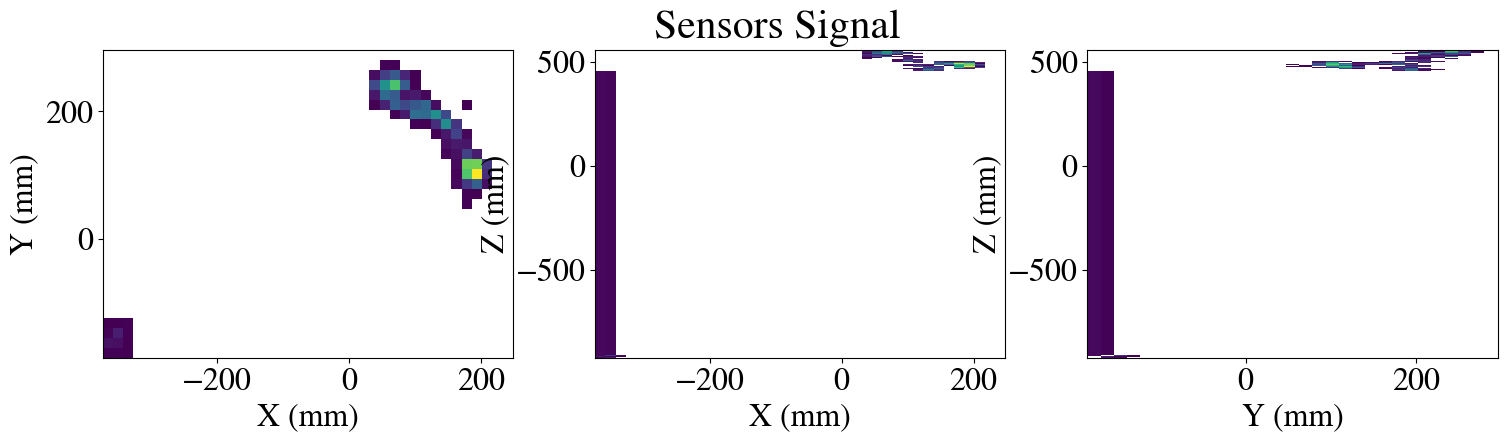

In [13]:
plot_hits(hits_deco, bins)
pitch = 15.55
xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_drop.Z.unique()
plot_hits(hits_deco, bins = (xx, yy, zz))

# compare deconvolved hits from initial hits.

In [14]:
def h5_deets(h5):
    # number of rows
    print(h5.shape)

print('hits')
print('=' * 20)
h5_deets(hits)

print('hits_deco')
print('=' * 20)
h5_deets(hits_deco)

hits
(1248, 17)
hits_deco
(20165, 8)


In [15]:
# attempt rebinning

dx, dy, dz = 5, 5, 4

x_edge = np.arange(hits_deco.X.min(), hits_deco.X.max() + dx, dx)
y_edge = np.arange(hits_deco.Y.min(), hits_deco.Y.max() + dy, dy)
z_edge = np.arange(hits_deco.Z.min(), hits_deco.Z.max() + dz, dz)

H, edges = np.histogramdd(
                        sample = np.vstack([hits_deco.X, hits_deco.Y, hits_deco.Z]).T,
                        bins   = [x_edge, y_edge, z_edge],
                        weights = hits_deco.E
)

print(f"Shape: {H.shape}")
print(edges)

Shape: (117, 93, 370)
[array([-371.125, -366.125, -361.125, -356.125, -351.125, -346.125,
       -341.125, -336.125, -331.125, -326.125, -321.125, -316.125,
       -311.125, -306.125, -301.125, -296.125, -291.125, -286.125,
       -281.125, -276.125, -271.125, -266.125, -261.125, -256.125,
       -251.125, -246.125, -241.125, -236.125, -231.125, -226.125,
       -221.125, -216.125, -211.125, -206.125, -201.125, -196.125,
       -191.125, -186.125, -181.125, -176.125, -171.125, -166.125,
       -161.125, -156.125, -151.125, -146.125, -141.125, -136.125,
       -131.125, -126.125, -121.125, -116.125, -111.125, -106.125,
       -101.125,  -96.125,  -91.125,  -86.125,  -81.125,  -76.125,
        -71.125,  -66.125,  -61.125,  -56.125,  -51.125,  -46.125,
        -41.125,  -36.125,  -31.125,  -26.125,  -21.125,  -16.125,
        -11.125,   -6.125,   -1.125,    3.875,    8.875,   13.875,
         18.875,   23.875,   28.875,   33.875,   38.875,   43.875,
         48.875,   53.875,   58.875,   

In [16]:
# 3. Compute voxel centers
x_centers = (x_edge[:-1] + x_edge[1:]) / 2
y_centers = (y_edge[:-1] + y_edge[1:]) / 2
z_centers = (z_edge[:-1] + z_edge[1:]) / 2

# 4. Build a DataFrame with each voxel → xyz + energy
xx, yy, zz = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")

df = pd.DataFrame({
    "event": hits.event.unique()[0],
    "npeak": hits.npeak.unique()[0],
    "X": xx.ravel(),
    "Y": yy.ravel(),
    "Z": zz.ravel(),
    "E": H.ravel(),
    "Ec": H.ravel(),
})

# Optional: remove empty voxels
df = df[df["Ec"] > 0].reset_index(drop=True)


In [17]:
# lets try and extract the indices once

In [18]:
display(hits.columns)
display(hits)

display(df)

Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
52082,57037,1.751991e+09,0,-171.760897,-49.048123,1,-451.525,-294.825,0.0,0.0,-931.133614,7.309861,321.651062,-1.0,NaN,-1,-1.0
52083,57037,1.751991e+09,0,-171.760897,-49.048123,1,-359.225,-155.875,0.0,0.0,-927.197223,8.071969,306.110397,-1.0,0.001604,-1,-1.0
52084,57037,1.751991e+09,0,-171.760897,-49.048123,1,-343.675,-155.875,0.0,0.0,-927.197223,7.946406,301.348729,-1.0,0.001546,-1,-1.0
52085,57037,1.751991e+09,0,-171.760897,-49.048123,1,-373.775,-171.425,0.0,0.0,-923.407253,7.198445,125.479546,-1.0,0.000694,-1,-1.0
52086,57037,1.751991e+09,0,-171.760897,-49.048123,1,-359.225,-171.425,0.0,0.0,-923.407253,11.755236,204.911153,-1.0,0.001089,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53325,57037,1.751991e+09,24,76.672308,111.034828,1,88.725,230.375,0.0,0.0,555.910250,8.589403,69.550571,-1.0,0.000370,-1,-1.0
53326,57037,1.751991e+09,24,76.672308,111.034828,1,88.725,245.925,0.0,0.0,555.910250,13.593873,110.073031,-1.0,0.000587,-1,-1.0
53327,57037,1.751991e+09,24,76.672308,111.034828,1,57.625,260.475,0.0,0.0,555.910250,11.895000,96.316829,-1.0,0.000511,-1,-1.0
53328,57037,1.751991e+09,24,76.672308,111.034828,1,73.175,260.475,0.0,0.0,555.910250,9.864754,79.877408,-1.0,0.000425,-1,-1.0


,event,npeak,X,Y,Z,E,Ec
0,57037,0,-368.625,-163.925,-921.407253,0.000032,0.000032
1,57037,0,-368.625,-158.925,-921.407253,0.000262,0.000262
2,57037,0,-368.625,-153.925,-921.407253,0.000054,0.000054
3,57037,0,-368.625,-143.925,-917.407253,0.000009,0.000009
4,57037,0,-368.625,-138.925,-917.407253,0.000029,0.000029
...,...,...,...,...,...,...,...
1236,57037,0,206.375,121.075,482.592747,0.000956,0.000956
1237,57037,0,206.375,126.075,466.592747,0.000057,0.000057
1238,57037,0,211.375,81.075,482.592747,0.000056,0.000056
1239,57037,0,211.375,111.075,466.592747,0.000551,0.000551


,event,npeak,X,Y,Z,E,Ec
0,57037,0,-368.625,-163.925,-921.407253,0.000032,0.000032
1,57037,0,-368.625,-158.925,-921.407253,0.000262,0.000262
2,57037,0,-368.625,-153.925,-921.407253,0.000054,0.000054
3,57037,0,-368.625,-143.925,-917.407253,0.000009,0.000009
4,57037,0,-368.625,-138.925,-917.407253,0.000029,0.000029
...,...,...,...,...,...,...,...
1236,57037,0,206.375,121.075,482.592747,0.000956,0.000956
1237,57037,0,206.375,126.075,466.592747,0.000057,0.000057
1238,57037,0,211.375,81.075,482.592747,0.000056,0.000056
1239,57037,0,211.375,111.075,466.592747,0.000551,0.000551


(1241, 7)
(938, 18)


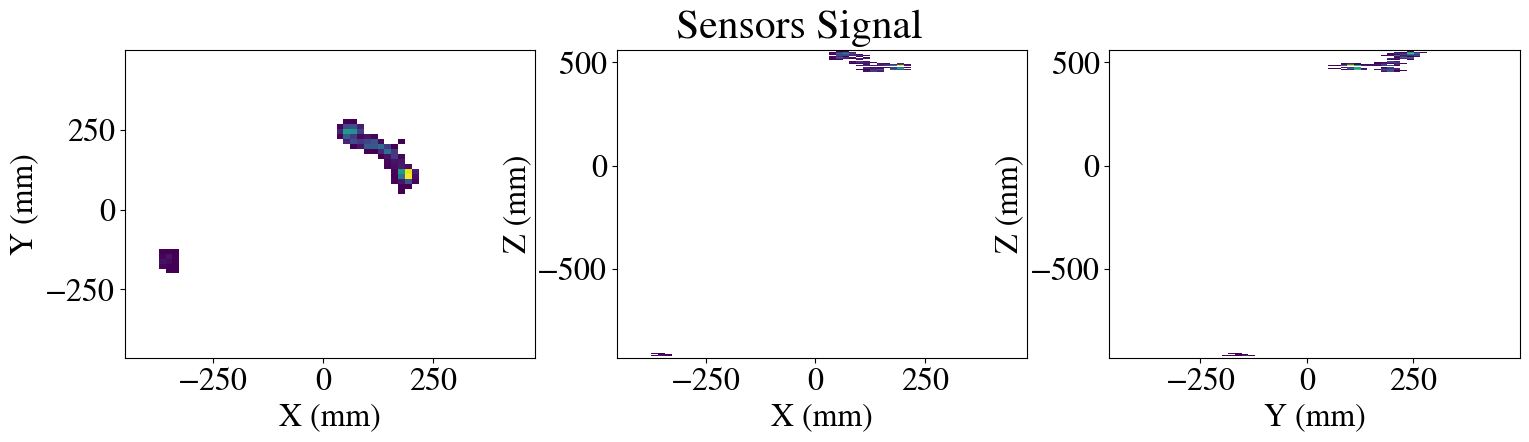

In [19]:
display(df)

plot_hits(df, bins)

h5_deets(df)
h5_deets(hits_drop)

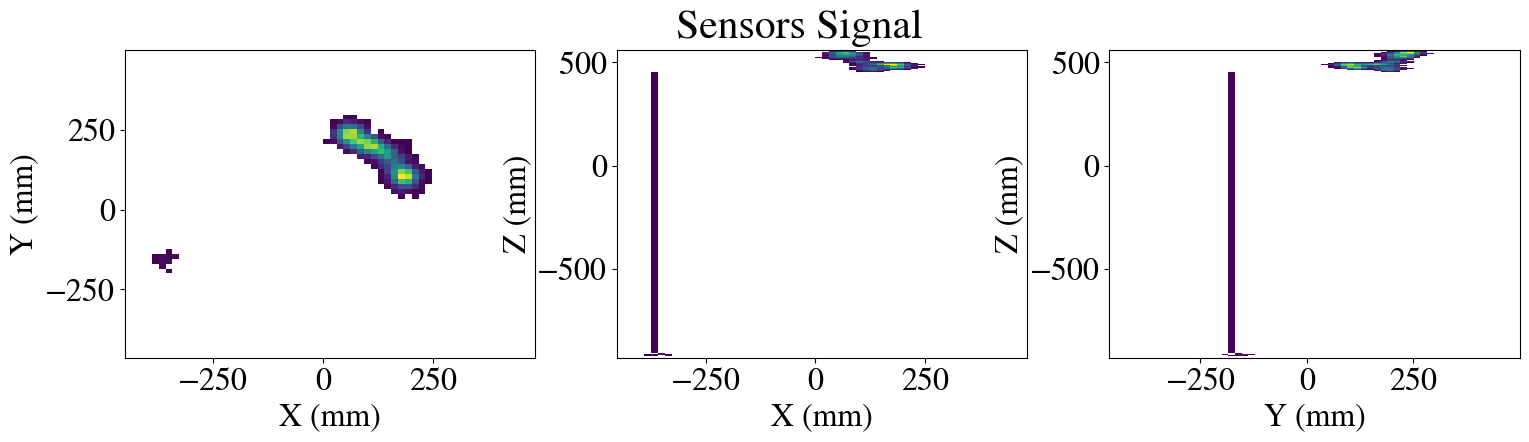

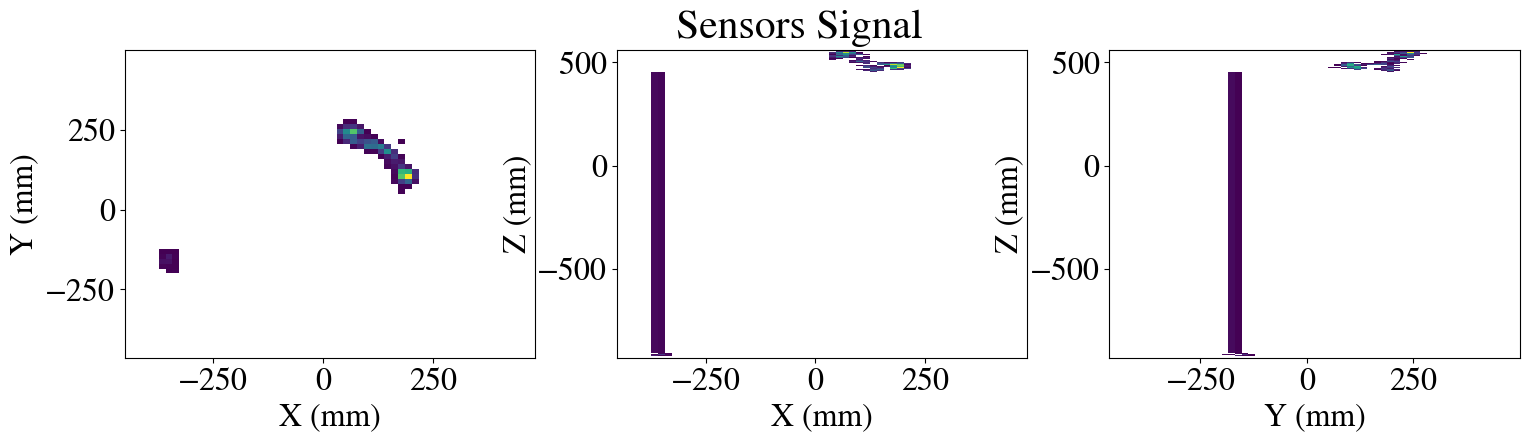

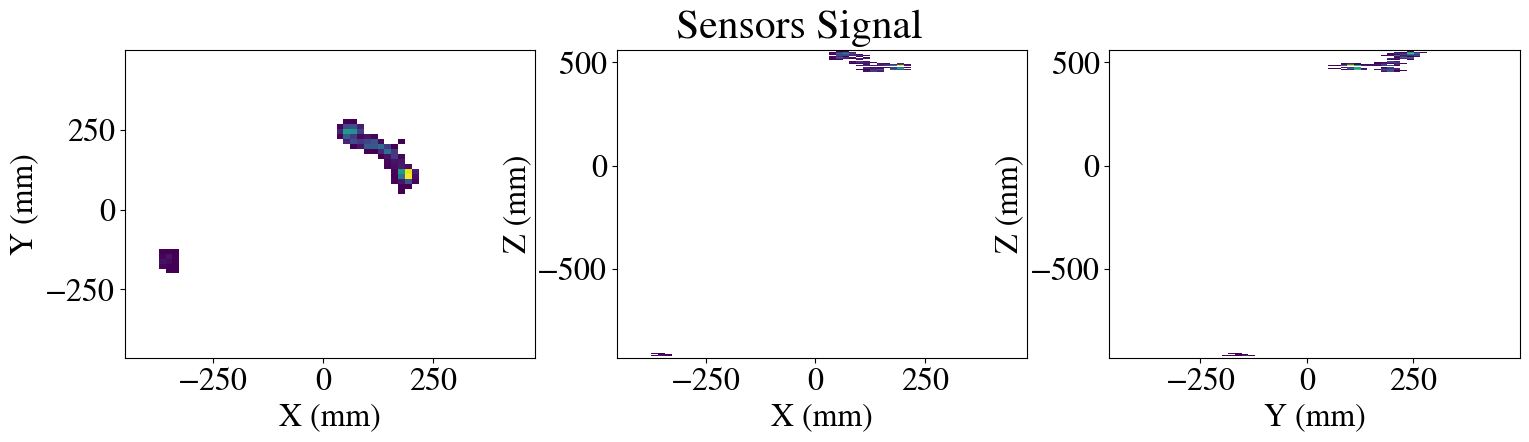

In [20]:
plot_hits(hits_drop, bins)
plot_hits(hits_deco, bins)
plot_hits(df, bins)



# Remove isolated clusters again

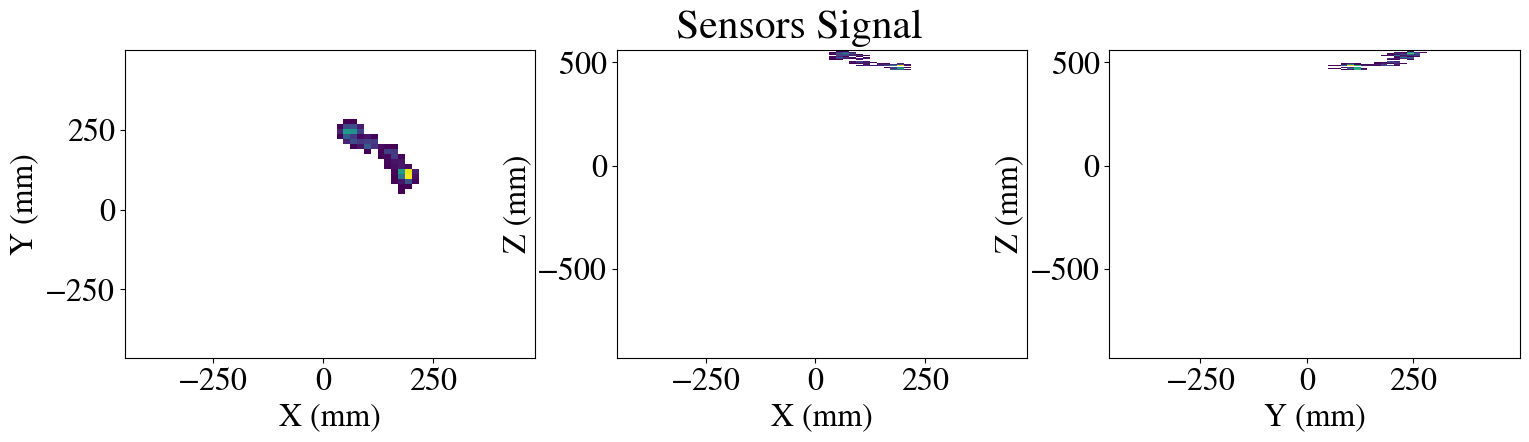

In [21]:
nhits_second = 100
drop_sensors_second      = drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'], nhits_second)


hits_double_drop = drop_sensors_second(df.copy())
plot_hits(hits_double_drop, bins)

# comprar

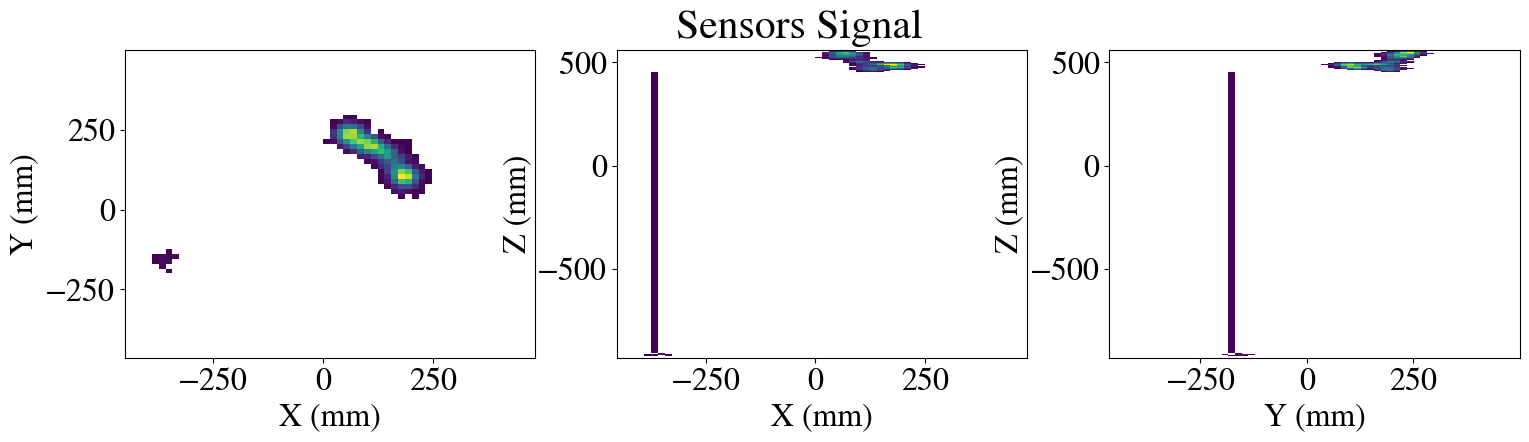

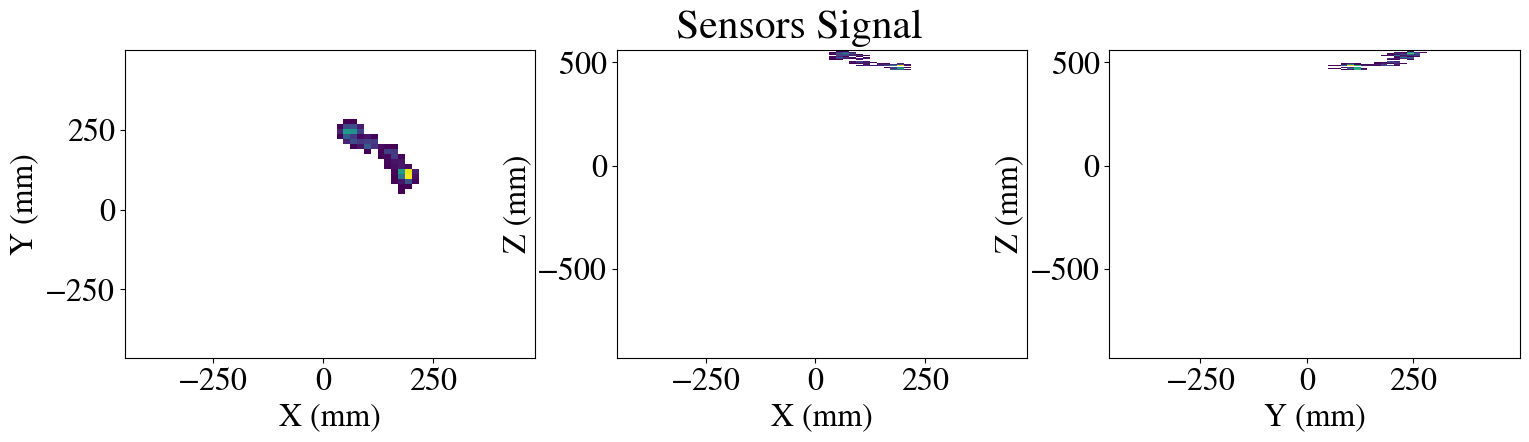

In [22]:
plot_hits(hits_drop, bins)
plot_hits(hits_double_drop, bins)

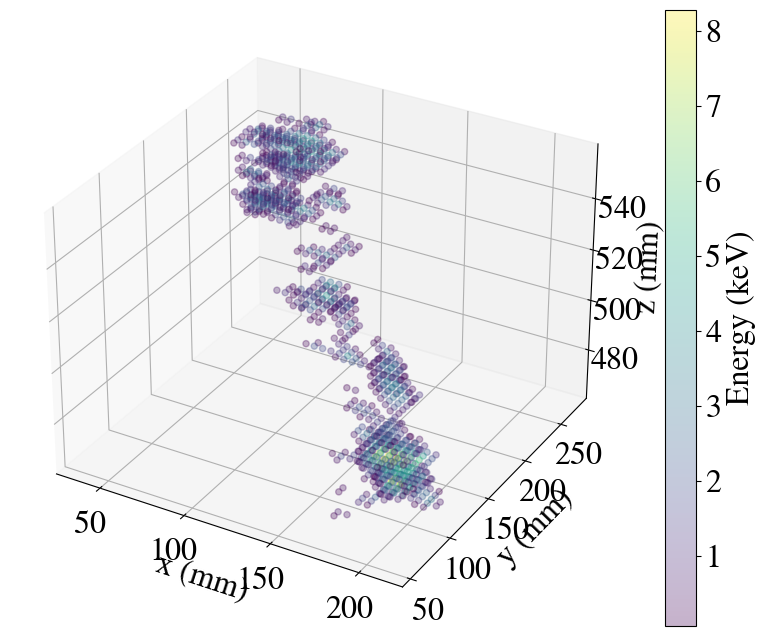

In [23]:
x = hits_double_drop.X
y = hits_double_drop.Y
z = hits_double_drop.Z
e = hits_double_drop.E*1000

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

plt.show()

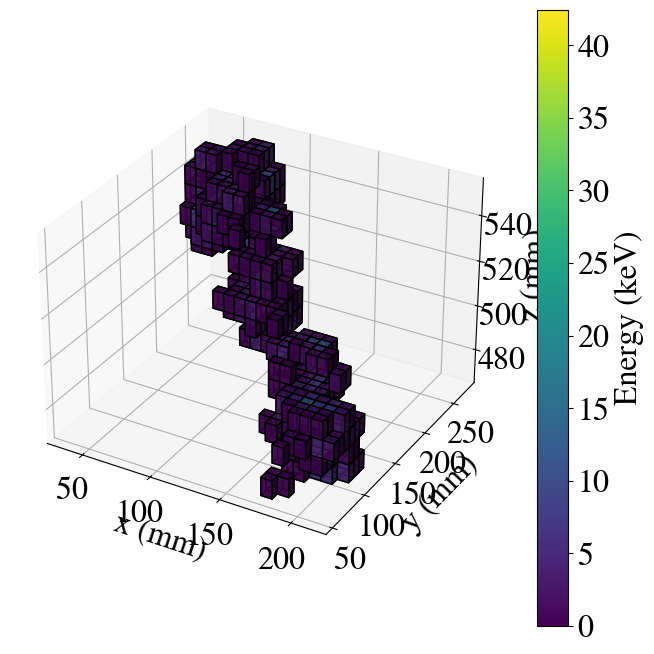

In [133]:
base_vsize = 8 #mm
the_hits = []

xs = hits_double_drop.X
ys = hits_double_drop.Y
zs = hits_double_drop.Z
es = hits_double_drop.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

# quick recheck of data

is this data fucked, or is my function fucked?

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
0,820,21.0,-251.125,276.575,901.554375,0.000035,-104.543570,137.072686,1.751990e+09,0,0,0
1,820,21.0,-251.125,277.575,901.554375,0.000034,-104.543570,137.072686,1.751990e+09,0,0,0
2,820,21.0,-250.125,275.575,901.554375,0.000033,-104.543570,137.072686,1.751990e+09,0,0,0
3,820,21.0,-250.125,276.575,901.554375,0.000041,-104.543570,137.072686,1.751990e+09,0,0,0
4,820,21.0,-250.125,277.575,901.554375,0.000040,-104.543570,137.072686,1.751990e+09,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
139281,1303,40.0,67.875,-137.425,1495.790750,0.000009,25.663403,-51.020662,1.751990e+09,0,0,0
139282,1303,40.0,67.875,-136.425,1495.790750,0.000009,25.663403,-51.020662,1.751990e+09,0,0,0
139283,1303,40.0,67.875,-135.425,1495.790750,0.000009,25.663403,-51.020662,1.751990e+09,0,0,0
139284,1303,40.0,67.875,-134.425,1495.790750,0.000008,25.663403,-51.020662,1.751990e+09,0,0,0


No binning provided, extracting from hits


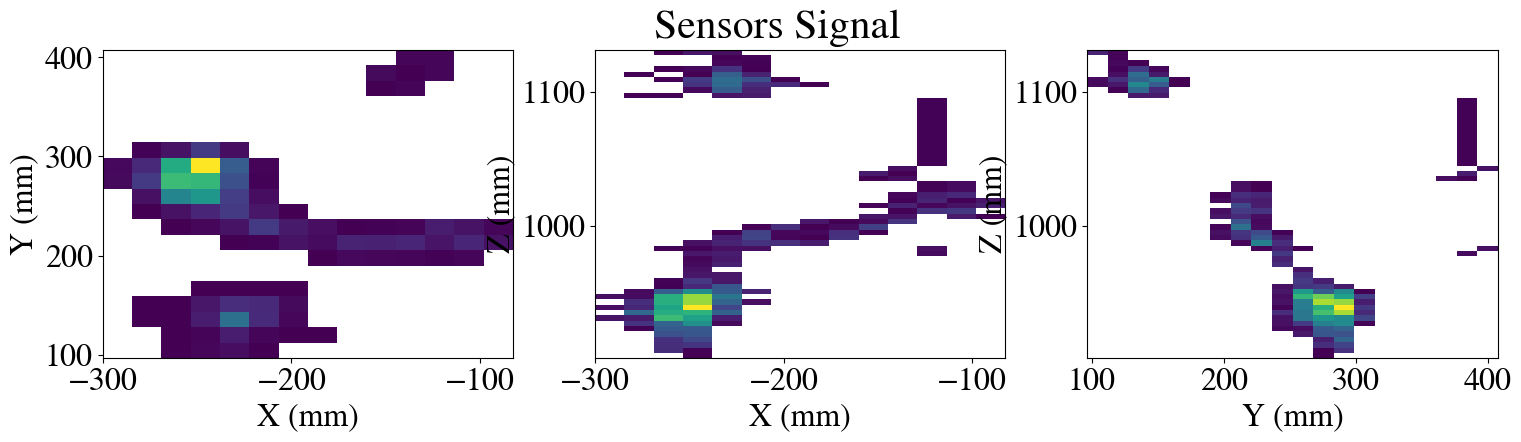

In [28]:
# load in the goofy data
check_df = dstio.load_dst('/home/e78368jw/Documents/NEXT_CODE/next_misc/beersheba_work/data/shire_test/in_files/run_15589_0001_ldc1_230725_beersheba.h5', 'DECO', 'Events')
display(check_df)

plot_hits(check_df[check_df.event==check_df.event.unique()[0]])

### rebin this bad boy

In [30]:
hits_new = check_df[check_df.event == check_df.event.unique()[0]]
# attempt rebinning

dx, dy, dz = 5, 5, 4

x_edge = np.arange(hits_new.X.min(), hits_new.X.max() + dx, dx)
y_edge = np.arange(hits_new.Y.min(), hits_new.Y.max() + dy, dy)
z_edge = np.arange(hits_new.Z.min(), hits_new.Z.max() + dz, dz)

H, edges = np.histogramdd(
                        sample = np.vstack([hits_new.X, hits_new.Y, hits_new.Z]).T,
                        bins   = [x_edge, y_edge, z_edge],
                        weights = hits_new.E
)

print(f"Shape: {H.shape}")
print(edges)

Shape: (43, 62, 58)
[array([-300.125, -295.125, -290.125, -285.125, -280.125, -275.125,
       -270.125, -265.125, -260.125, -255.125, -250.125, -245.125,
       -240.125, -235.125, -230.125, -225.125, -220.125, -215.125,
       -210.125, -205.125, -200.125, -195.125, -190.125, -185.125,
       -180.125, -175.125, -170.125, -165.125, -160.125, -155.125,
       -150.125, -145.125, -140.125, -135.125, -130.125, -125.125,
       -120.125, -115.125, -110.125, -105.125, -100.125,  -95.125,
        -90.125,  -85.125]), array([ 96.575, 101.575, 106.575, 111.575, 116.575, 121.575, 126.575,
       131.575, 136.575, 141.575, 146.575, 151.575, 156.575, 161.575,
       166.575, 171.575, 176.575, 181.575, 186.575, 191.575, 196.575,
       201.575, 206.575, 211.575, 216.575, 221.575, 226.575, 231.575,
       236.575, 241.575, 246.575, 251.575, 256.575, 261.575, 266.575,
       271.575, 276.575, 281.575, 286.575, 291.575, 296.575, 301.575,
       306.575, 311.575, 316.575, 321.575, 326.575, 331.575, 

In [35]:
# 3. Compute voxel centers
x_centers = (x_edge[:-1] + x_edge[1:]) / 2
y_centers = (y_edge[:-1] + y_edge[1:]) / 2
z_centers = (z_edge[:-1] + z_edge[1:]) / 2

# 4. Build a DataFrame with each voxel → xyz + energy
xx, yy, zz = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")

df = pd.DataFrame({
    "event": hits_new.event.unique()[0],
    "npeak": hits_new.npeak.unique()[0],
    "X": xx.ravel(),
    "Y": yy.ravel(),
    "Z": zz.ravel(),
    "E": H.ravel(),
    "Ec": H.ravel(),
})

# Optional: remove empty voxels
df = df[df["Ec"] > 0].reset_index(drop=True)


In [36]:
display(df)

,event,npeak,X,Y,Z,E,Ec
0,820,21.0,-297.625,279.075,927.554375,0.000567,0.000567
1,820,21.0,-297.625,279.075,943.554375,0.000069,0.000069
2,820,21.0,-297.625,284.075,927.554375,0.000572,0.000572
3,820,21.0,-297.625,284.075,943.554375,0.000070,0.000070
4,820,21.0,-292.625,279.075,927.554375,0.000827,0.000827
...,...,...,...,...,...,...,...
1657,820,21.0,-87.625,214.075,1015.554375,0.000902,0.000902
1658,820,21.0,-87.625,219.075,1011.554375,0.000617,0.000617
1659,820,21.0,-87.625,219.075,1015.554375,0.000889,0.000889
1660,820,21.0,-87.625,224.075,1011.554375,0.000850,0.000850


# Glue